In [ ]:
# visualizes the group parcellations (averaged across the subjects) for all task/contrasts

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting.find_cuts import find_cut_slices

In [2]:
# general helper functions:
def cleanup_memory():
    """
    Clean up memory between batches
    """
    # Force garbage collection
    gc.collect()
    
    # Get memory info
    memory = psutil.virtual_memory()
    print(f"Memory after cleanup: {memory.percent:.1f}% used ({memory.available/(1024**3):.1f}GB available)")

In [3]:
# all tasks and contrasts
TASKS = ["nBack","flanker","directedForgetting","goNogo", "shapeMatching", "stopSignal", "cuedTS", "spatialTS"]
CONTRASTS = {}
CONTRASTS["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"] # the nback contrasts
CONTRASTS["flanker"] = ["incongruent-congruent", "task-baseline"]
CONTRASTS["directedForgetting"] = ["neg-con", "task-baseline","response_time"]
CONTRASTS["goNogo"] = ["nogo_success-go", "nogo_success","task-baseline","response_time"] # go_rtModel check
CONTRASTS["shapeMatching"] = ["DDD", "DDS", "DNN", "DSD", "main_vars", "SDD", "SNN", "SSS", "task-baseline","response_time"]
CONTRASTS["stopSignal"] = ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
CONTRASTS["cuedTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]
CONTRASTS["spatialTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]

# interested in looking at them all now:
requested_task_contrasts = defaultdict(lambda: defaultdict(list))
requested_task_contrasts['nBack'] = CONTRASTS["nBack"]
requested_task_contrasts['flanker'] = CONTRASTS["flanker"]
requested_task_contrasts['directedForgetting'] = CONTRASTS["directedForgetting"]
requested_task_contrasts['goNogo'] = CONTRASTS["goNogo"]
requested_task_contrasts['shapeMatching'] = CONTRASTS["shapeMatching"]
requested_task_contrasts['stopSignal'] = CONTRASTS["stopSignal"]
requested_task_contrasts['cuedTS'] = CONTRASTS["cuedTS"]
requested_task_contrasts['spatialTS'] = CONTRASTS["spatialTS"] 

# compiled_req_contrasts = ["twoBack-oneBack", 'task-baseline', "incongruent-congruent", "neg-con", "nogo_success-go", "main_vars", "stop_failure-go","task_switch_cost"]
# compile all requested contrasts into one list
compiled_req_contrasts = []
for task in TASKS:
    for contrast in requested_task_contrasts[task]:
        if (contrast not in compiled_req_contrasts):
            compiled_req_contrasts.append(contrast)


ENCOUNTERS = ['01', '02','03','04','05']
SUBJECTS = ['sub-s03', 'sub-s10', 'sub-s19', 'sub-s29', 'sub-s43']

In [4]:
SCHAFER_PARCELLATED_DIR = 'schafer400_dfs'
schafer_files = {'mean':f'discovery_parcel_indiv_mean_updated'}
date_updated = '1001'
indices = [1,2,3]

# Get atlas
SCHAEFER = datasets.fetch_atlas_schaefer_2018(n_rois=400)
SCHAEFER_IMG = nib.load(SCHAEFER.maps)
SCHAEFER_DATA = SCHAEFER_IMG.get_fdata()

[get_dataset_dir] Dataset found in /home/users/nklevak/nilearn_data/schaefer_2018

# Load the averaged parcel results

In [10]:
avg_parcel_traj_results = {}
mean_filename = f"{SCHAFER_PARCELLATED_DIR}/{schafer_files['mean']}_{date_updated}_averaged.pkl"

with open(mean_filename, 'rb') as f:
    avg_parcel_traj_results = pickle.load(f)

# Visualizing functions

In [7]:
def create_parcel_practice_heatmap(parcel_traj, title, indiv_data = True, n_rows=50):
    """
    Create a heatmap showing practice effects across all parcels

    input:
    parcel_traj: a df of parcels and activations 
    title: the title for this heatmap
    """
    
    # Prepare data for heatmap
    df = pd.DataFrame(parcel_traj).T

    if (indiv_data):
        # Sort by slope
        df_sorted = df.sort_values('slope', key=abs).head(n_rows)
        # Create trajectory matrix
        trajectory_matrix = np.array([row['trajectory'] for _, row in df_sorted.iterrows()])
    else:
        # Sort by avg slope
        df_sorted = df.sort_values('slope_mean', key=abs).head(n_rows)
        # Create trajectory matrix
        trajectory_matrix = np.array([row['trajectory_mean'] for _, row in df_sorted.iterrows()])
    
    
    
    # Create the heatmap
    plt.figure(figsize=(30, 12))
    
    # Plot trajectories
    sns.heatmap(trajectory_matrix, 
                xticklabels=['Enc 1', 'Enc 2', 'Enc 3', 'Enc 4', 'Enc 5'],
                yticklabels=[row.name for _, row in df_sorted.iterrows()],
                cmap='RdBu_r', center=0, 
                cbar_kws={'label': 'Activation'})
    
    plt.title('Practice Effects Across All Parcels')
    plt.xlabel('Encounter')
    plt.ylabel('Brain Parcel ID')
        
    plt.title(f"{title}: first {n_rows} rows")
    plt.tight_layout()
    plt.show()

In [14]:
# Calculate fixed coordinates once based on atlas - SELECT SINGLE MIDDLE COORDINATES
FIXED_X_CUT = int(np.median(find_cut_slices(SCHAEFER_IMG, direction='x', n_cuts=10)))
FIXED_Y_CUT = int(np.median(find_cut_slices(SCHAEFER_IMG, direction='y', n_cuts=10)))  
FIXED_Z_CUT = int(np.median(find_cut_slices(SCHAEFER_IMG, direction='z', n_cuts=10)))

print("Fixed coordinates that will be used:")
print("X:", FIXED_X_CUT)
print("Y:", FIXED_Y_CUT) 
print("Z:", FIXED_Z_CUT)

def plot_slopes_on_brain(avg_results, task, contrast, n_rois=400, atlas=SCHAEFER, atlas_img=SCHAEFER_IMG, atlas_data=SCHAEFER_DATA, title="Average parcel slopes (top 10%):", threshold="default"):
    """
    Plot parcel slope means on brain using Schaefer atlas labels
    """
    # Get atlas labels
    atlas_labels = [label.decode('utf-8') if isinstance(label, bytes) else label 
                   for label in atlas.labels]
    
    # Get slope data
    parcel_data = avg_results[task][contrast]
    
    # Create brain image with slope values
    slope_data = np.zeros_like(atlas_data)
    
    # Map parcel names to atlas regions
    for i, atlas_label in enumerate(atlas_labels):
        if atlas_label in parcel_data:
            slope_value = parcel_data[atlas_label]['slope_mean']
            slope_data[atlas_data == (i + 1)] = slope_value

    # Create and plot
    slope_img = nib.Nifti1Image(slope_data, atlas_img.affine)

    # create a percentile based threshold (only plot the top 10% magnitudes of slope values)
    all_slopes = np.abs([stats['slope_mean'] for stats in parcel_data.values()])

    # Use the SAME coordinates for ALL plots
    fixed_cut_coords = (FIXED_X_CUT, FIXED_Y_CUT, FIXED_Z_CUT)

    # if no threshold specified it does top 10%, else it does the threshold that's passed in
    if (threshold == "default"):
        threshold = np.percentile(all_slopes, 90)
        plotting.plot_stat_map(slope_img,
                      title=f'{title} Practice Effects: {task}/{contrast}',
                      colorbar=True,
                      cmap='RdBu_r',
                      symmetric_cbar=True,
                      threshold=threshold,
                      display_mode='mosaic',
                      cut_coords=fixed_cut_coords)  # Use fixed coordinates
    else:
        title = "Average parcel slopes (unthresholded):"
        plotting.plot_stat_map(slope_img,
                      title=f'{title} Practice Effects: {task}/{contrast}',
                      colorbar=True,
                      cmap='RdBu_r',
                      symmetric_cbar=True,
                      threshold=None,
                      display_mode='mosaic',
                      cut_coords=fixed_cut_coords)  # Use fixed coordinates
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    # Print top 20 practice effects table
    slope_data_list = [(parcel_name, stats['slope_mean']) for parcel_name, stats in parcel_data.items()]
    slope_df = pd.DataFrame(slope_data_list, columns=['Parcel_Name', 'Slope'])
    slope_df['Abs_Slope'] = np.abs(slope_df['Slope'])
    top_slopes = slope_df.nlargest(20, 'Abs_Slope')
    
    print(f"\nTop 50 Practice Effects for {task}/{contrast}")
    print("="*80)
    print(f"{'Rank':<5} {'Region':<50} {'Slope':<10} {'Direction':<12}")
    print("-"*80)
    
    for i, (_, row) in enumerate(top_slopes.iterrows(), 1):
        parcel_name = row['Parcel_Name']
        slope = row['Slope']
        direction = "Improvement" if slope > 0 else "Decline"
        # Truncate long region names
        short_name = parcel_name[:47] + "..." if len(parcel_name) > 50 else parcel_name
        print(f"{i:<5} {short_name:<50} {slope:<10.4f} {direction:<12}")

Fixed coordinates that will be used:
X: 20
Y: 3
Z: 16


# visualizing the averaged parcel slopes

In [ ]:
count = 0
for task in requested_task_contrasts:
    if (count > 3):
        break
    contrast = requested_task_contrasts[task][0]
    title = f"{task}:{contrast} heatmap of avg parcel activation (all subjects) over encounters, sorted from largest avg abs slope to smallest"

    create_parcel_practice_heatmap(avg_parcel_traj_results[task][contrast],title,indiv_data=False,n_rows=10)
    count += 1

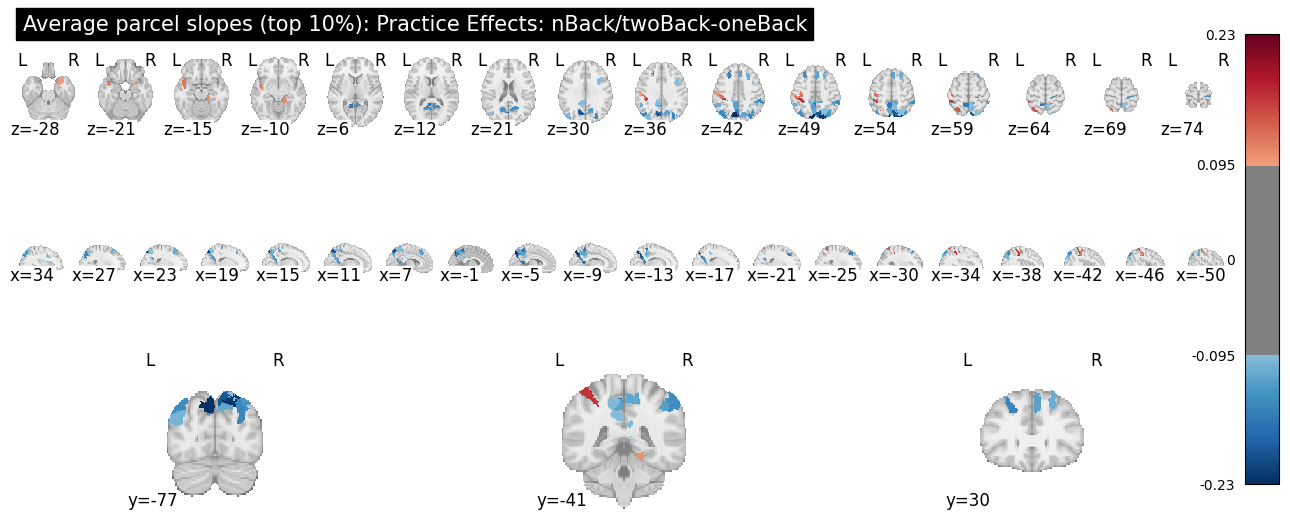


Top 50 Practice Effects for nBack/twoBack-oneBack
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_LH_Cont_pCun_1                           -0.2250    Decline     
2     7Networks_RH_DorsAttn_Post_7                       -0.2184    Decline     
3     7Networks_RH_DorsAttn_Post_15                      -0.1903    Decline     
4     7Networks_LH_Default_pCunPCC_5                     -0.1896    Decline     
5     7Networks_LH_Default_pCunPCC_1                     -0.1653    Decline     
6     7Networks_LH_SalVentAttn_Med_6                     -0.1615    Decline     
7     7Networks_LH_DorsAttn_Post_11                      0.1601     Improvement 
8     7Networks_LH_Default_pCunPCC_10                    -0.1515    Decline     
9     7Networks_LH_Default_PFC_16                        -0.1479    Decline     
10    7Networks_RH_Vis_30                                -

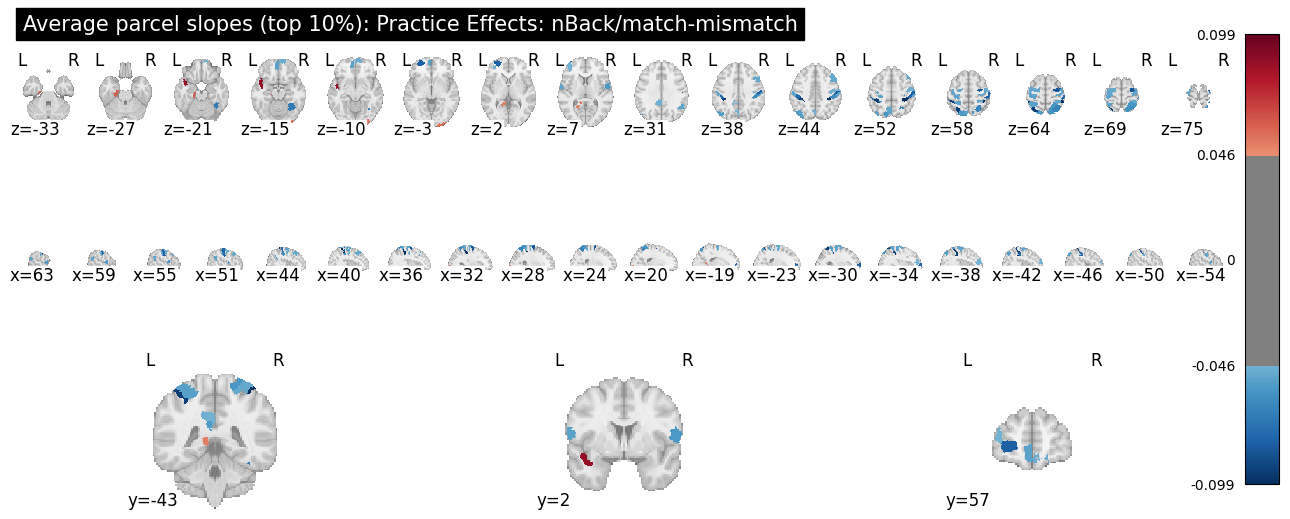


Top 50 Practice Effects for nBack/match-mismatch
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_RH_DorsAttn_Post_13                      -0.0990    Decline     
2     7Networks_LH_DorsAttn_Post_11                      -0.0933    Decline     
3     7Networks_LH_DorsAttn_Post_14                      -0.0929    Decline     
4     7Networks_LH_SalVentAttn_FrOperIns_1               0.0873     Improvement 
5     7Networks_RH_SomMot_31                             -0.0843    Decline     
6     7Networks_RH_SomMot_19                             -0.0815    Decline     
7     7Networks_LH_Default_PFC_6                         -0.0806    Decline     
8     7Networks_RH_SomMot_23                             -0.0790    Decline     
9     7Networks_LH_DorsAttn_Post_8                       -0.0773    Decline     
10    7Networks_RH_Vis_3                                 -0

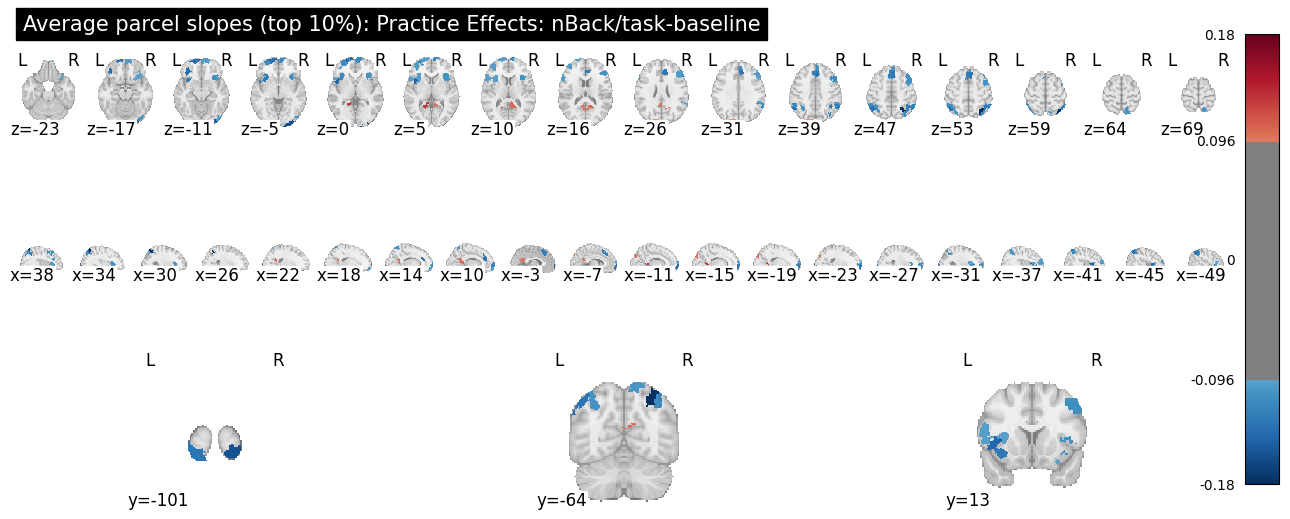


Top 50 Practice Effects for nBack/task-baseline
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_RH_DorsAttn_Post_10                      -0.1808    Decline     
2     7Networks_RH_Vis_13                                -0.1582    Decline     
3     7Networks_LH_SalVentAttn_FrOperIns_7               -0.1429    Decline     
4     7Networks_LH_Limbic_OFC_5                          -0.1371    Decline     
5     7Networks_LH_Default_PFC_2                         -0.1361    Decline     
6     7Networks_LH_Default_Par_7                         -0.1332    Decline     
7     7Networks_LH_Vis_12                                -0.1312    Decline     
8     7Networks_RH_Cont_PFCmp_2                          -0.1306    Decline     
9     7Networks_RH_Cont_PFCmp_1                          -0.1289    Decline     
10    7Networks_LH_Cont_PFCv_1                           -0.

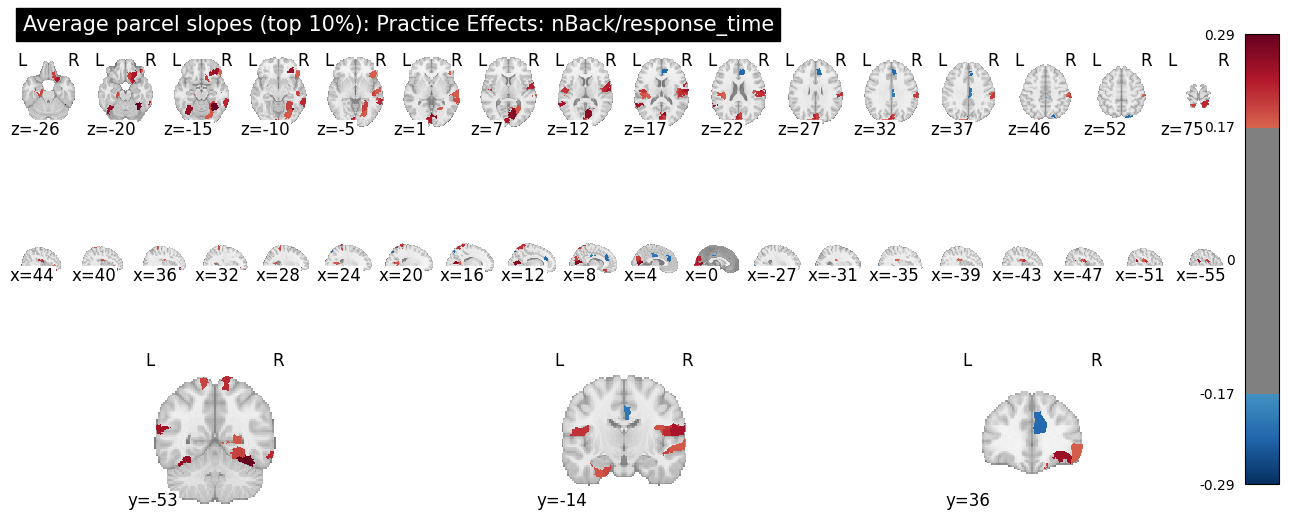


Top 50 Practice Effects for nBack/response_time
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_RH_Vis_3                                 0.2929     Improvement 
2     7Networks_RH_Vis_19                                0.2644     Improvement 
3     7Networks_LH_Vis_3                                 0.2569     Improvement 
4     7Networks_RH_Default_PFCv_2                        0.2496     Improvement 
5     7Networks_LH_Default_Par_1                         0.2432     Improvement 
6     7Networks_RH_SomMot_14                             0.2402     Improvement 
7     7Networks_RH_Limbic_OFC_2                          0.2360     Improvement 
8     7Networks_LH_Vis_18                                0.2347     Improvement 
9     7Networks_RH_Cont_PFCmp_1                          -0.2286    Decline     
10    7Networks_RH_DorsAttn_Post_7                       -0.

In [15]:
# Plot all contrasts 
count = 0
for task in avg_parcel_traj_results.keys():
    if (count > 3):
        break
    for contrast in avg_parcel_traj_results[task].keys():
        if len(avg_parcel_traj_results[task][contrast]) > 0: 
            plot_slopes_on_brain(avg_parcel_traj_results, task, contrast)
            count += 1

In [ ]:
# do the same thing but with an unthresholded brain
# Plot all contrasts with no threshold
for task in avg_parcel_traj_results.keys():
    for contrast in avg_parcel_traj_results[task].keys():
        if len(avg_parcel_traj_results[task][contrast]) > 0: 
            plot_slopes_on_brain(avg_parcel_traj_results, task, contrast, threshold = "")

In [ ]:
# get the average trajectory and fit a new linear model to it to see how that 
# differs from the averaged slope maps (this might get severaly impacted by one or two subjects though)

